<h1> Binance Data Science & Algorithm Internship Take Home Assessment </h1>

<h2> Part 2 Questions </h2>
○	Tell us how you validate your model and why you chose such evaluation technique(s). <br>

○	What is AUC? Why do you think AUC was used as the evaluation metric for this challenge? What other metrics do you think would also be suitable for this competition? <br>

○	Short explanation of what you tried. What worked and what did not work (ie. you might have tried different features/models before the final one).<br>

○	What insight(s) do you have from your model(s)?<br>

○	Can you get into the top 100 of the private leaderboard or even higher? <br>


In [107]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install -U scikit-learn
!pip install xgboost


Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
Looking in indexes: https://pypi.python.org/simple/, https://nexus3.sqcorp.co/repository/pypi-all/simple
  Using cached lightgbm-3.3.3.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [86 lines of output]
      running bdist_wheel
      /opt/homebrew/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: s

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

<h2> Load and Explore Datasets </h2>

In [54]:
train = pd.read_csv('../data/cs-training.csv')
test = pd.read_csv('../data/cs-test.csv')
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [55]:
train.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
test.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

In [56]:
P = train.groupby('SeriousDlqin2yrs')['ID'].count().reset_index()
P['Percentage'] = 100 * P['ID'] / P['ID'].sum()
print(P)

   SeriousDlqin2yrs      ID  Percentage
0                 0  139974      93.316
1                 1   10026       6.684


<h2> Preprocessing </h2>
Age is assumed to be between 18 and 100 for loans. Check outliers and clean the dataset. <br>
When there is a "0" value age, or null value monthly income, these entries will be replaced by the median/ mean value.

In [57]:
train.loc[train['age'] == 0, 'age'] = train['age'].median()
train['MonthlyIncome'] = train['MonthlyIncome'].replace(np.nan,train['MonthlyIncome'].mean())
train['NumberOfDependents'].fillna(train['NumberOfDependents'].median(), inplace=True)

<h3> Check Data Using Confusion Matrix </h3>

<AxesSubplot: >

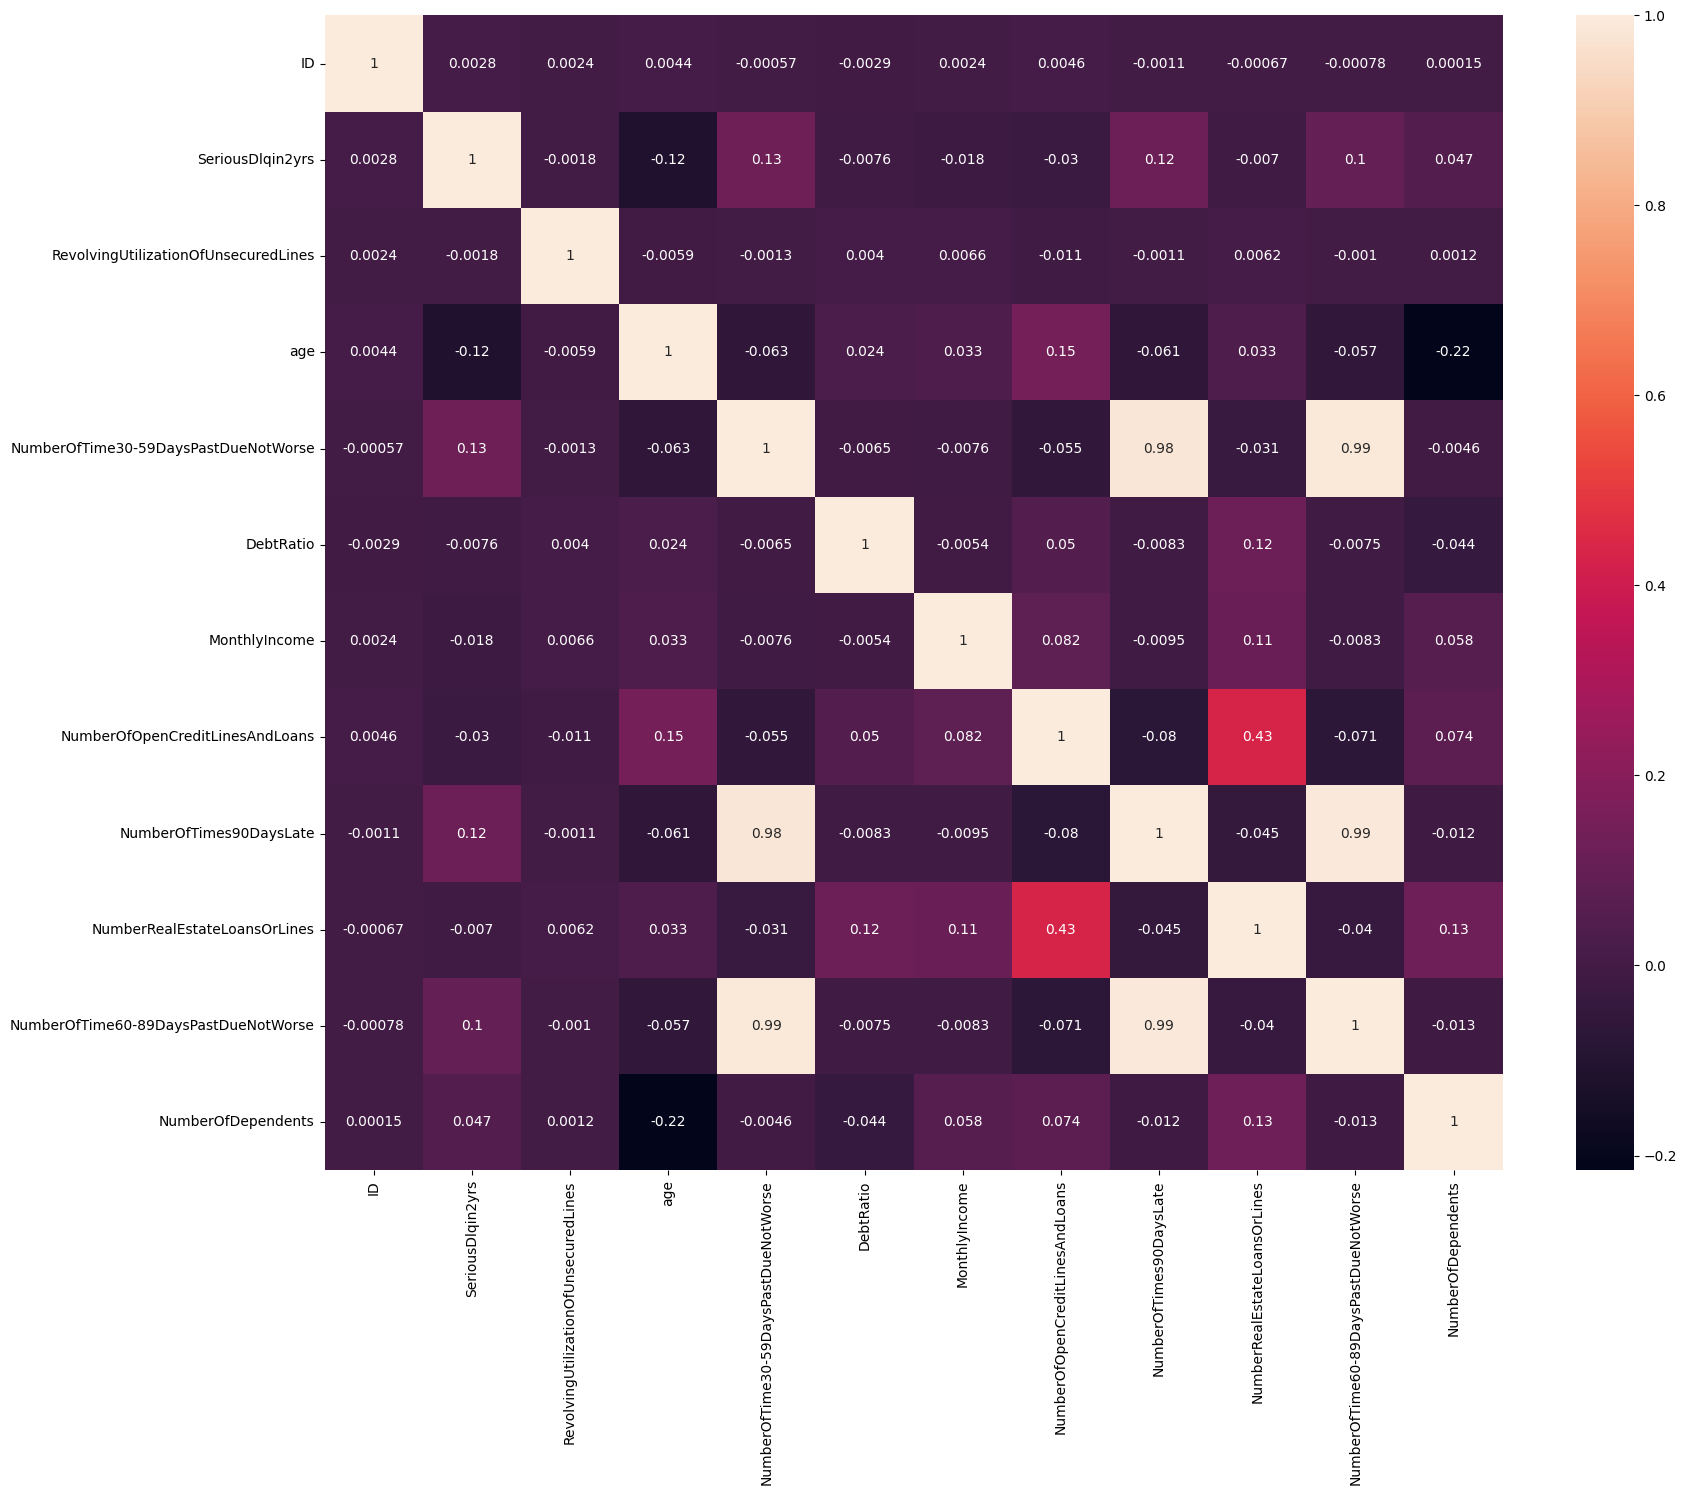

In [58]:
corr = train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr, annot=True)

Here we see that outliers exist in:

- 'NumberOfTime30-59DaysPastDueNotWorse', 
- 'NumberOfTime60-89DaysPastDueNotWorse',
- 'NumberOfTimes90DaysLate'.

Boxplot these features to see where this occurs, then replace outlier values with the median value.

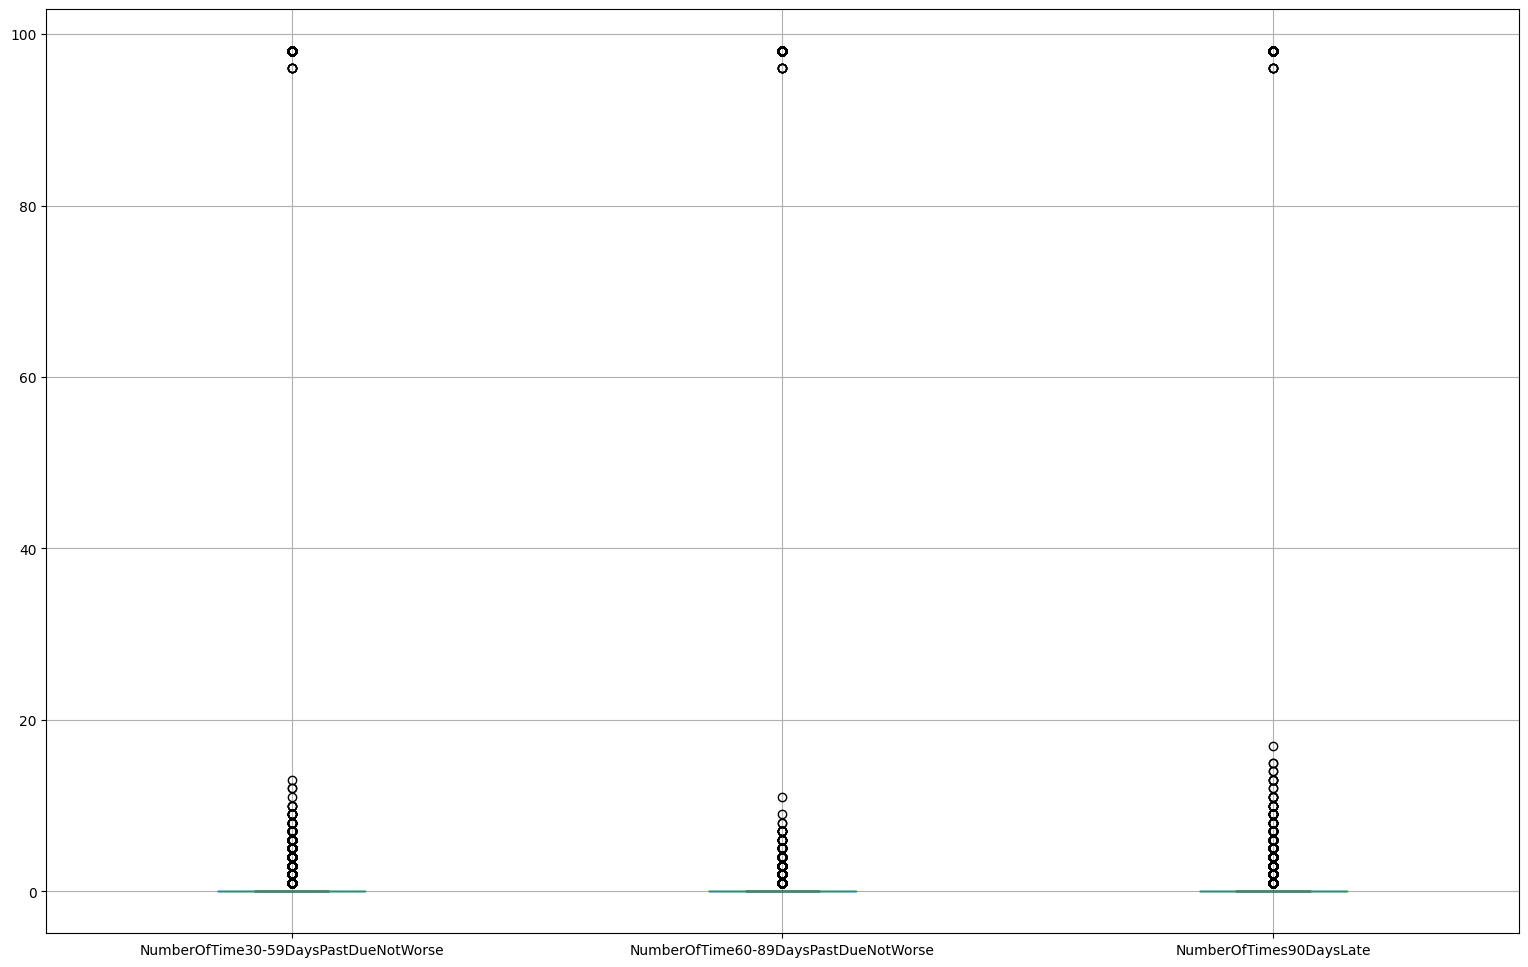

In [59]:
plt.figure(figsize=(19, 12)) 
train[['NumberOfTime30-59DaysPastDueNotWorse', 
          'NumberOfTime60-89DaysPastDueNotWorse',
          'NumberOfTimes90DaysLate']].boxplot()
plt.show()

In [75]:
def replace98and99(column):
    new = []
    newval = column.median()
    for i in column:
        if (i == 98 or i == 99):
            new.append(newval)
        else:
            new.append(i)
    return new

In [76]:
train['NumberOfTime30-59DaysPastDueNotWorse'] = replace98and99(train['NumberOfTime30-59DaysPastDueNotWorse'])
train['NumberOfTimes90DaysLate'] = replace98and99(train['NumberOfTimes90DaysLate'])
train['NumberOfTime60-89DaysPastDueNotWorse'] = replace98and99(train['NumberOfTime60-89DaysPastDueNotWorse'])

test['NumberOfTime30-59DaysPastDueNotWorse'] = replace98and99(test['NumberOfTime30-59DaysPastDueNotWorse'])
test['NumberOfTimes90DaysLate'] = replace98and99(test['NumberOfTimes90DaysLate'])
test['NumberOfTime60-89DaysPastDueNotWorse'] = replace98and99(test['NumberOfTime60-89DaysPastDueNotWorse'])

<AxesSubplot: >

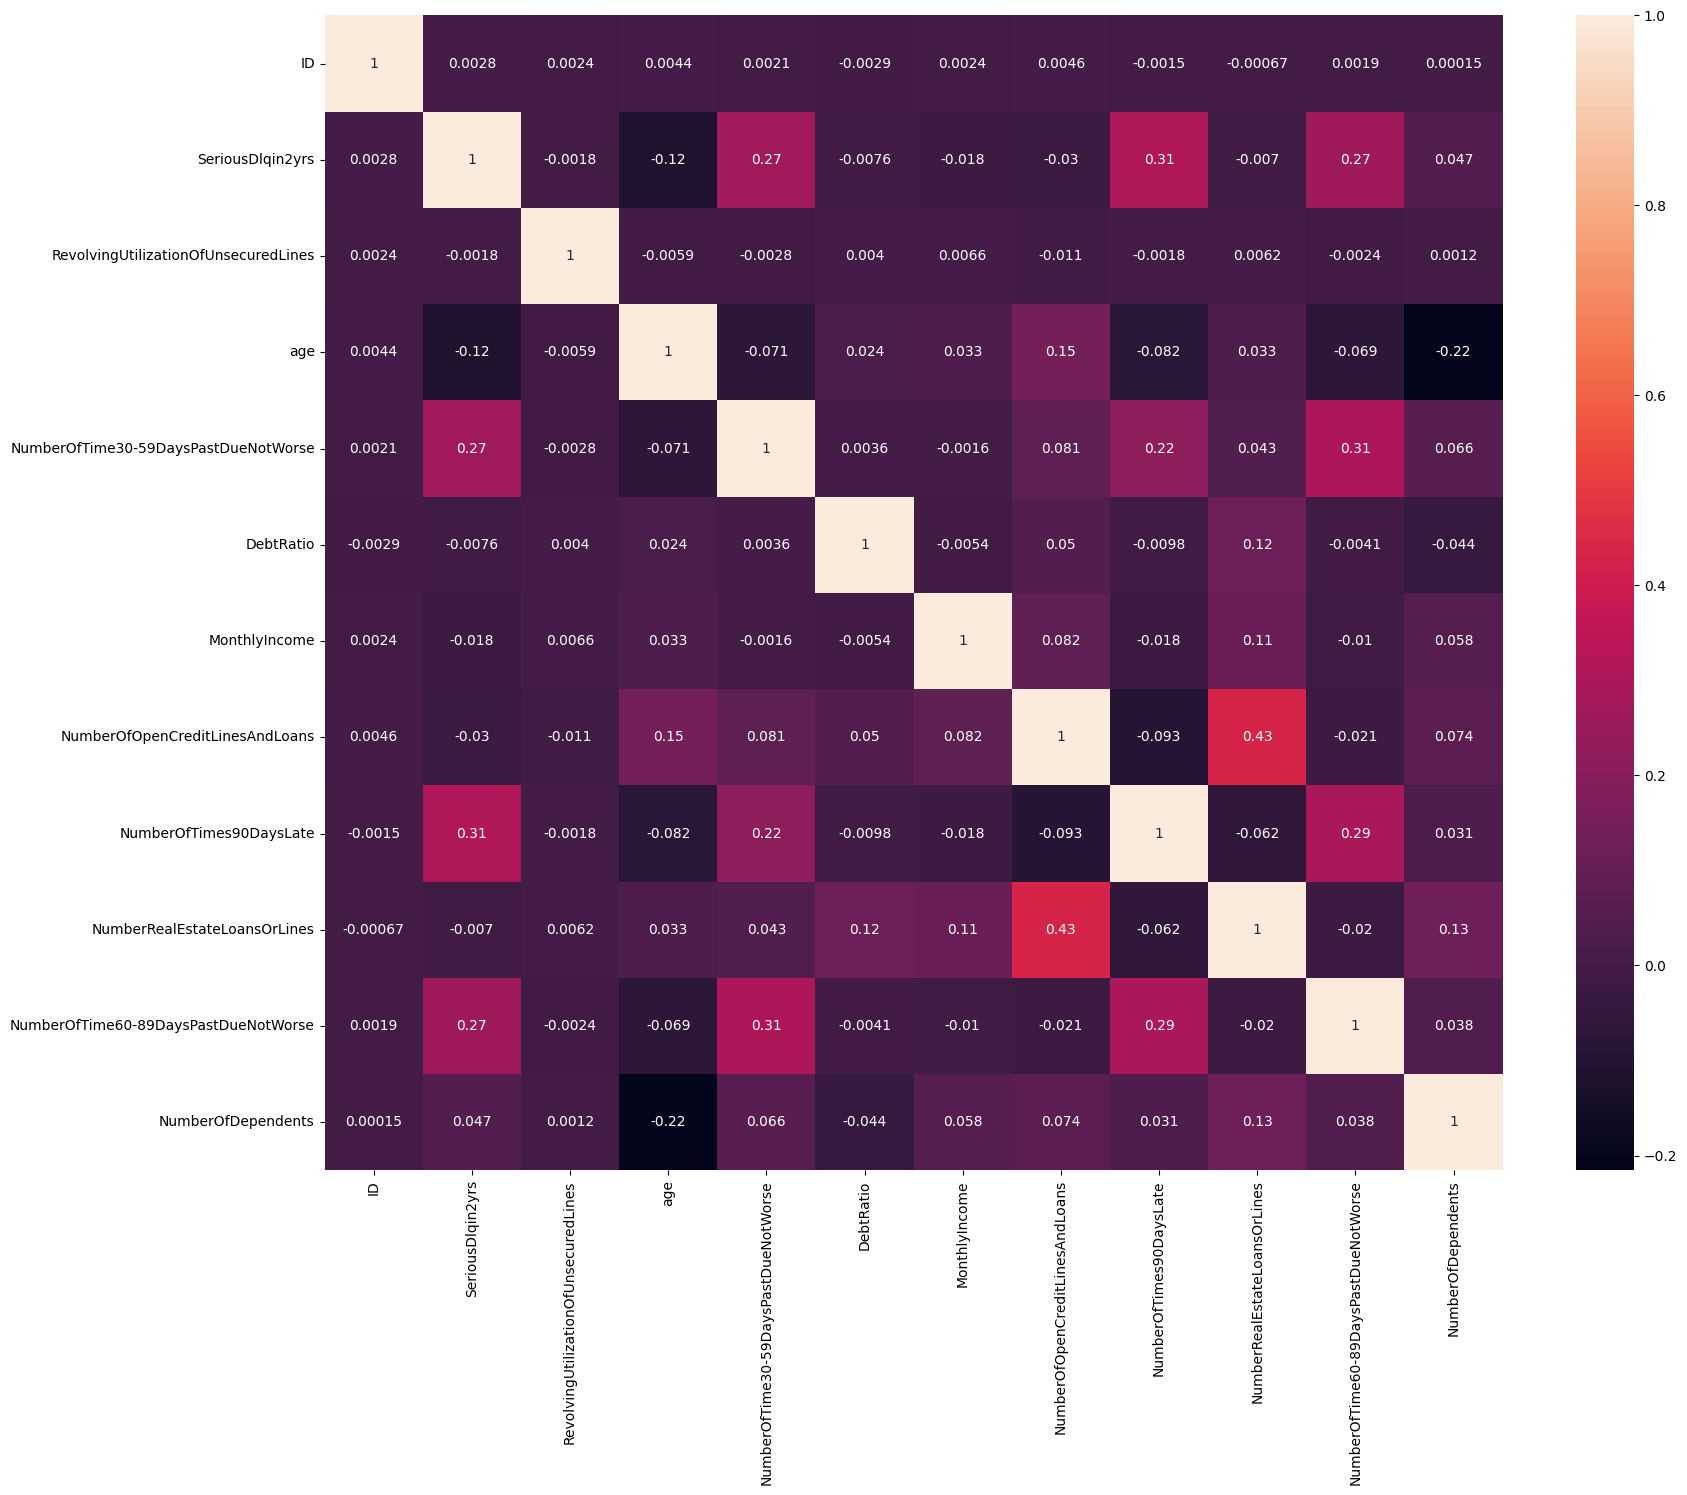

In [77]:
corr = train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr, annot=True)

<h2> Model </h2>

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

<h3> Extract train / test datasets </h3>

In [95]:
# Will be further split into train/test sets
X = train.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
Y = train['SeriousDlqin2yrs']

# For evaluating our model later
x = test.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = test['SeriousDlqin2yrs']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=111)

<h3> Logistic Regression </h3>

In [86]:
logit = LogisticRegression(random_state=111, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, Y_train)

logit_scores_proba = logit.predict_proba(X_train_scaled)
logit_scores = logit_scores_proba[:,1]

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

Train AUC Score :  0.8160882912599647


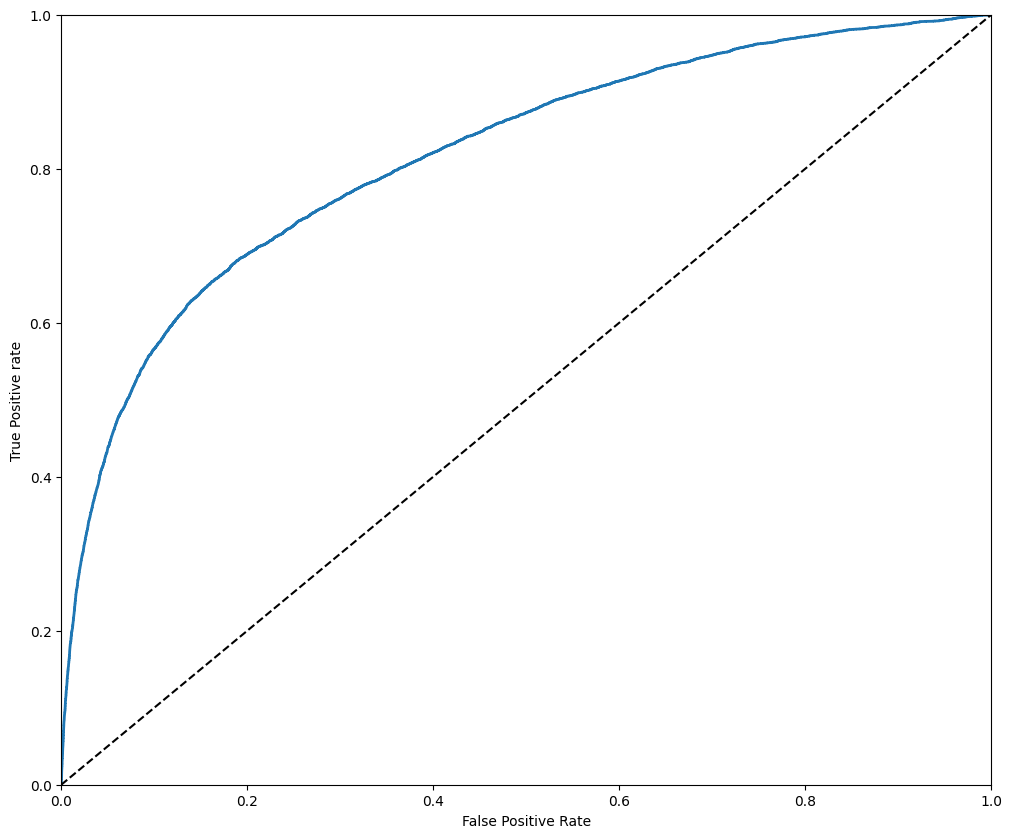

In [94]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(Y_train, logit_scores)

plot_roc_curve(fpr_logit,tpr_logit)
print('Train AUC Score : ', (roc_auc_score(Y_train,logit_scores)))

Test AUC Score : 0.8117632779507644


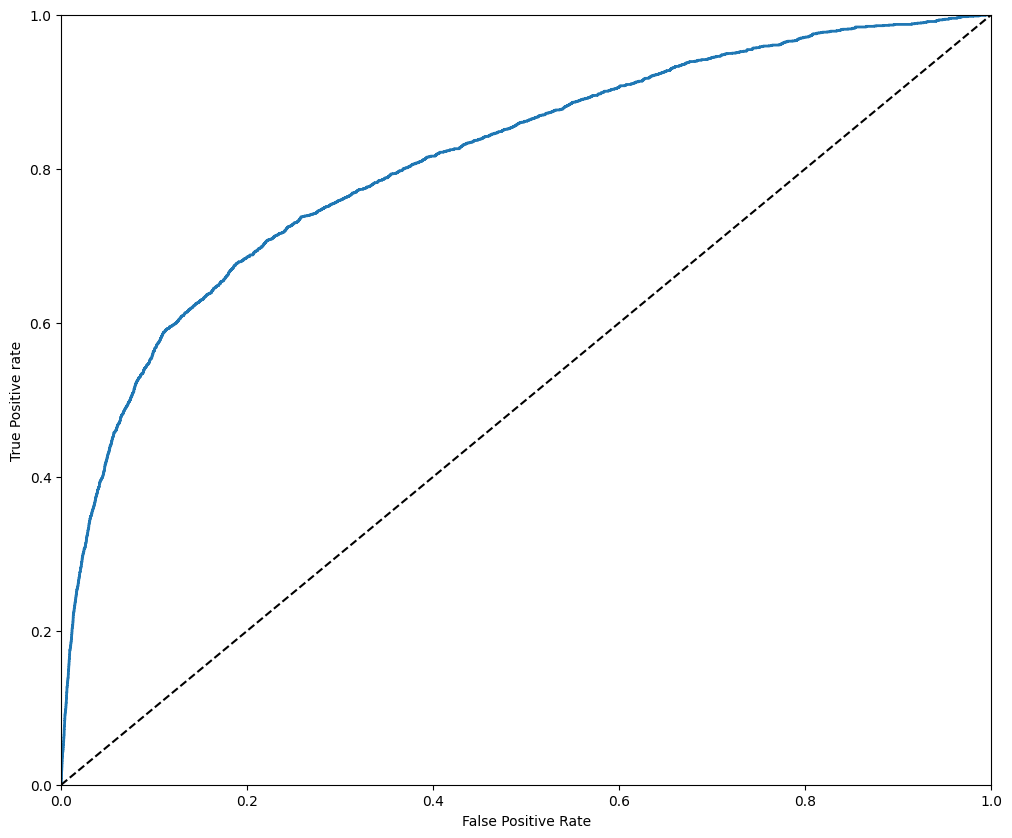

In [93]:
logit_scores_proba_val = logit.predict_proba(X_test_scaled)

logit_scores_val = logit_scores_proba_val[:,1]

fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(Y_test, logit_scores_val)

plot_roc_curve(fpr_logit_val,tpr_logit_val)
print('Test AUC Score :', (roc_auc_score(Y_test,logit_scores_val)))

<h3> K-Nearest Neighbors (KNN) </h3>

Logistic Regression AUC Score : 0.5824591257655662
Logistic Regression Cross Validation AUC Score : 0.5856970092173521


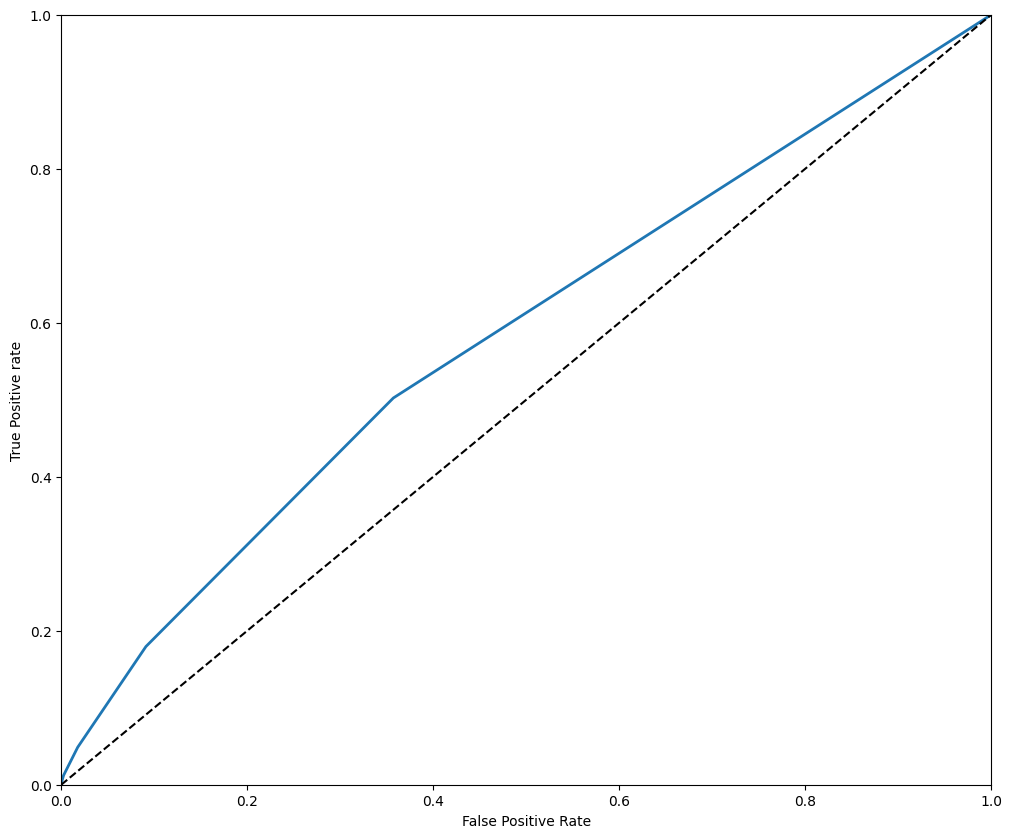

In [116]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)

# Predictions for test data
knn_pred = knn.predict_proba(X_test)[:,1]
# Evalulate predictions
fpr, tpr, _ = roc_curve(Y_test, knn_pred)

knn_roc_auc = auc(fpr,tpr)
knn_cv_roc_auc = cross_val_score(knn, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('Logistic Regression AUC Score :', knn_roc_auc)
print('Logistic Regression Cross Validation AUC Score :', knn_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> Random Forest Classifier </h3>

RandomForestClassifier AUC Score : 0.8613812325408617
RandomForestClassifier Cross Valication AUC Score : 0.8584418771144445


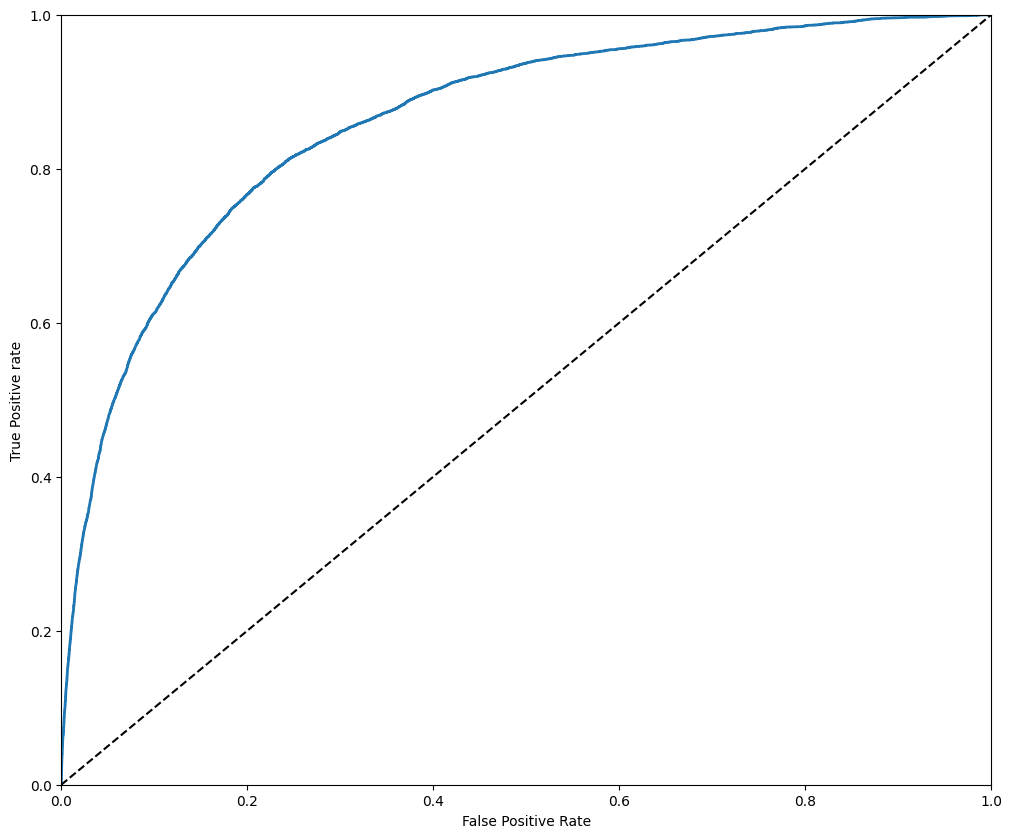

In [118]:
rfc = RandomForestClassifier(n_estimators=300, random_state=111, max_depth=5, class_weight='balanced')
rfc.fit(X_train, Y_train)

rfc_pred = rfc.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(Y_train, rfc_pred)

rfc_roc_auc = auc(fpr,tpr)
rfc_cv_roc_auc = cross_val_score(rfc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('RandomForestClassifier AUC Score :', rfc_roc_auc)
print('RandomForestClassifier Cross Valication AUC Score :', rfc_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> Gradient Boosting Classifier </h3>

GradientBoostingClassifier AUC Score : 0.8601580789803852
GradientBoostingClassifier CV AUC Score : 0.8640435910290725


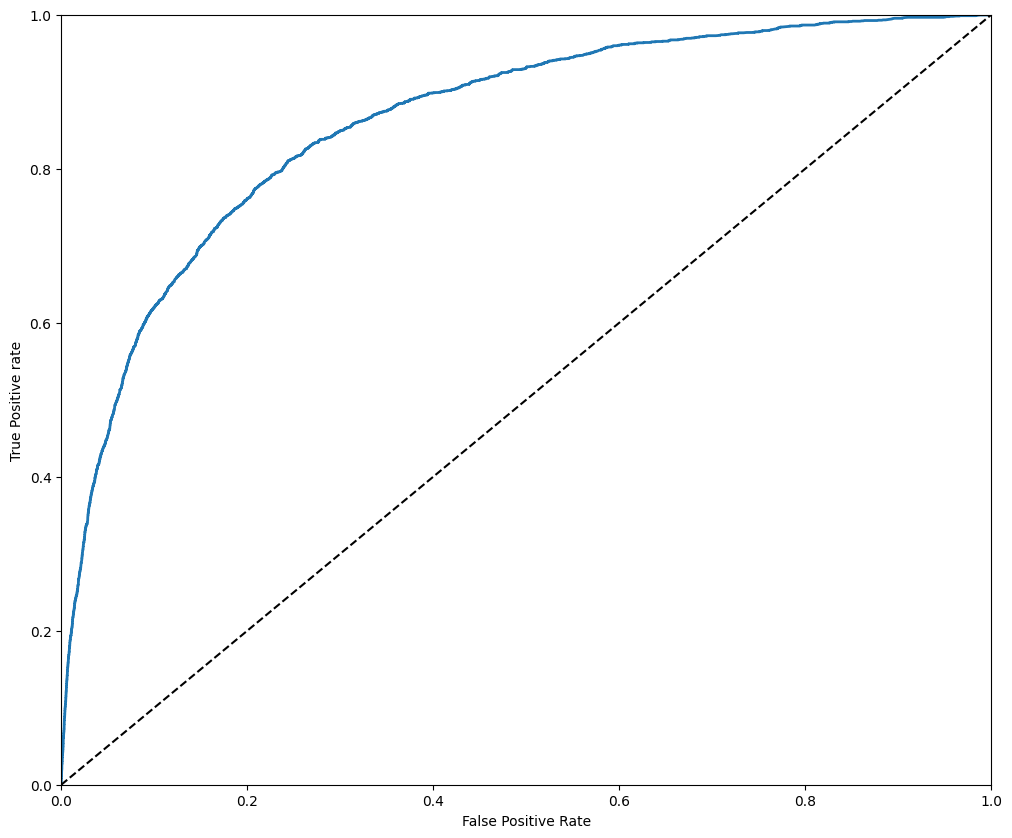

In [119]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,Y_train)

gbc_pred = gbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, gbc_pred)

gbc_roc_auc = auc(fpr,tpr)
gbc_cv_roc_auc = cross_val_score(gbc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('GradientBoostingClassifier AUC Score :', gbc_roc_auc)
print('GradientBoostingClassifier CV AUC Score :', gbc_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> XGBoost </h3>

XGBClassifier AUC Score : 0.857291128788876
XGBClassifier CV AUC Score : 0.8621137867082636


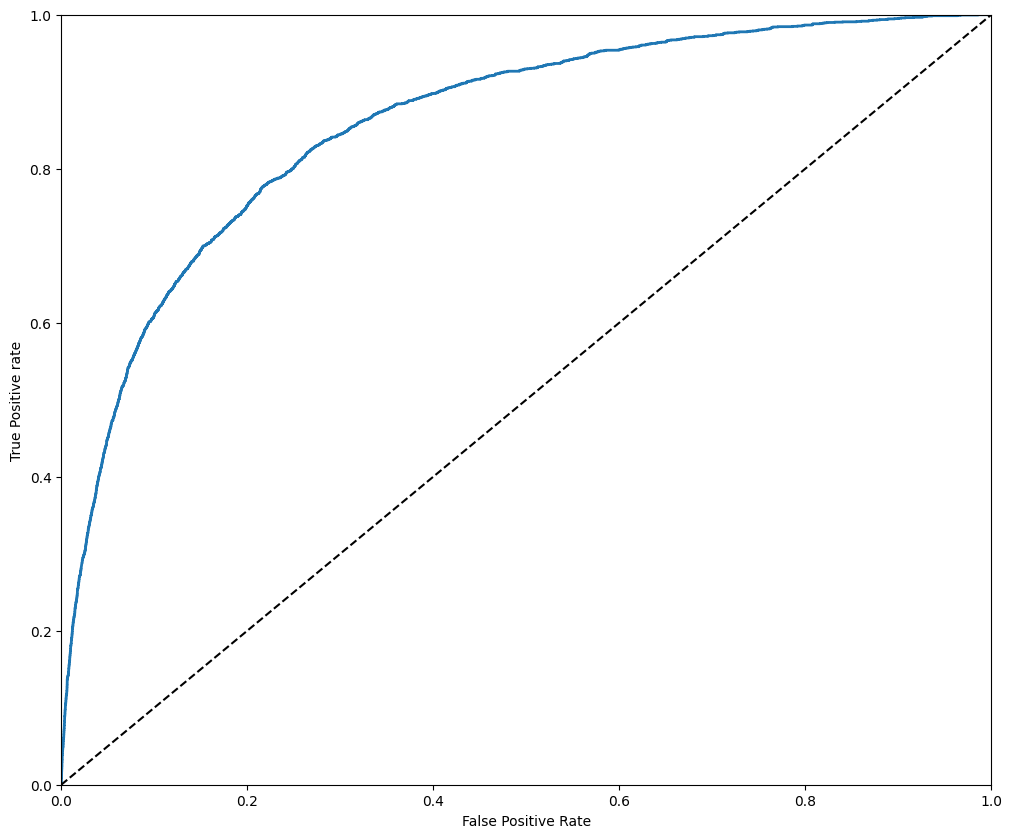

In [121]:
xgbc = XGBClassifier(max_depth=5,eval_metric='auc',objective='binary:logistic')
xgbc.fit(X_train, Y_train)

xgbc_pred = xgbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, xgbc_pred)

xgbc_roc_auc = auc(fpr,tpr)
xgbc_cv_roc_auc = cross_val_score(xgbc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

plot_roc_curve(fpr,tpr)
print ('XGBClassifier AUC Score :', xgbc_roc_auc)
print('XGBClassifier CV AUC Score :', xgbc_cv_roc_auc)